In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from sklearn.mixture import GaussianMixture
from budgetcb.constrained_cb import LinUCB, UcbAlp, HATCH
from budgetcb.constrained_mab import EpsGreedy
from budgetcb.replay import ReplayEvaluator

In [2]:
state = np.load('state.npy')
action = np.load('action.npy')
reward = np.load('reward.npy')
J = 10
gmm = GaussianMixture(n_components=J).fit(state)
pai = gmm.weights_

context_dic = dict(zip([i for i in range(J)], gmm.means_))

In [3]:
def get_payoffs(cb, action=action, reward=reward, state=state, batch_size=1):
    replay = ReplayEvaluator(cb, action, reward, state, batch_size)
    replay.evaluate()
    payoffs = replay.get_details().get('payoff_records')
    m = replay.get_details().get('match_num')
    return m, payoffs

In [4]:
ucbalp_policy = UcbAlp(narms=6, T=1000, B=300, pai=pai, gmm=gmm, dummy_arm=3)
greedy_policy = EpsGreedy(narms=6, epsilon=0, T=1000, B=300, dummy_arm=3)
random_policy = EpsGreedy(narms=6, epsilon=1, T=1000, B=300, dummy_arm=3)
linucb_policy = LinUCB(narms=6, ndims=5, alpha=0.1, T=1000, B=300, dummy_arm=3)
hatch_policy = HATCH(narms=6, alpha=0.1, gmm=gmm, J=10, pai=pai, B=300, T=1000, 
                     context_dic=context_dic, dummy_arm=3)

m1, ucbalp_payoff = get_payoffs(ucbalp_policy)
m2, greedy_payoff = get_payoffs(greedy_policy)
m3, random_payoff = get_payoffs(random_policy)
m4, linucb_payoff = get_payoffs(linucb_policy)
m5, hatch_payoff = get_payoffs(hatch_policy, batch_size=10)

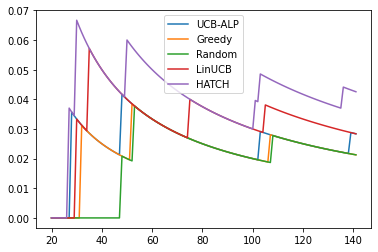

In [5]:
# rolling mean
cul_UCBALP = []
cul_greedy = []
cul_random = []
cul_linucb = []
cul_hatch = []

index = []

for i in range(20, min(m1,m2,m3,m4,m5)):
    cul_UCBALP.append(np.mean(ucbalp_payoff[:i]))
    cul_greedy.append(np.mean(greedy_payoff[:i]))   
    cul_random.append(np.mean(random_payoff[:i]))  
    cul_linucb.append(np.mean(linucb_payoff[:i])) 
    cul_hatch.append(np.mean(hatch_payoff[:i])) 
    
    index.append(i)
    
plt.plot(index, cul_UCBALP, label = "UCB-ALP")
plt.plot(index, cul_greedy, label = "Greedy")
plt.plot(index, cul_random, label = "Random")
plt.plot(index, cul_linucb, label = "LinUCB")
plt.plot(index, cul_hatch, label = "HATCH")
plt.legend();